In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from experiment import Experiment

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import time

from sklearn.model_selection import train_test_split,learning_curve,cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, get_scorer, confusion_matrix, ConfusionMatrixDisplay

from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPClassifier

from experiment import Experiment


In [2]:
exp=Experiment("WineQuality-RedWine.csv",'quality')
exp.preprocess(Pipeline(steps=[('ss',StandardScaler())]))

#Encode to make a binary problem
exp.y_train=np.apply_along_axis((lambda y: y>5),axis=0,arr=exp.y_train)
exp.y_test=np.apply_along_axis((lambda y: y>5),axis=0,arr=exp.y_test)

         count  percentage
quality                   
3           10    0.006254
4           53    0.033146
5          681    0.425891
6          638    0.398999
7          199    0.124453
8           18    0.011257


[array([[-0.18645827, -0.73692022,  0.53008583, -0.34812874],
        [ 0.05525833,  0.07498242, -0.50652265, -0.4441926 ],
        [-0.02519466, -0.09684749,  0.1333435 ,  0.51022787],
        [-0.15883785,  0.13917651, -0.45631587, -0.38223159],
        [ 0.39945954, -0.15409494,  0.22482587, -0.12728455],
        [ 0.24929933,  1.0894542 ,  0.31236771, -0.5605562 ],
        [ 0.04364647, -0.21058437,  0.0621068 ,  0.48750743],
        [-0.05186994, -0.54223547, -0.01997861,  0.15913794],
        [-0.6842466 ,  0.29260846,  0.18031085, -0.9944882 ],
        [-0.02254088,  0.55267952, -0.4181354 ,  0.00760174],
        [ 0.19077625, -0.01036574, -0.34485317,  0.02370063]]),
 array([[-0.77358192],
        [-0.54342187],
        [ 1.32199239],
        [-0.89446621]])]

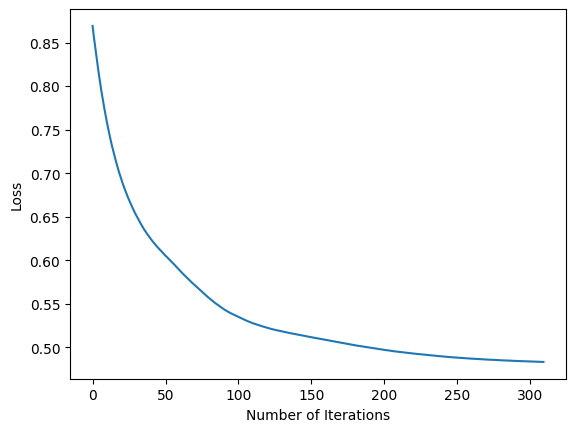

In [3]:
nn_opt=MLPClassifier(hidden_layer_sizes=4,learning_rate_init=0.001,max_iter=1000)
nn_opt.fit(exp.X_train,exp.y_train)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.plot(nn_opt.loss_curve_)
nn_opt.coefs_


=============Step size 0.1======================
Train score: 0.768
Test score: 0.760
Iterations: 1733.60
Evaluations: 2195.40
Fit Times: 0.599
=============Step size 0.01======================
Train score: 0.777
Test score: 0.754
Iterations: 15341.60
Evaluations: 20656.60
Fit Times: 5.56
=============Step size 0.001======================
Train score: 0.779
Test score: 0.752
Iterations: 141481.60
Evaluations: 197216.20
Fit Times: 53.7


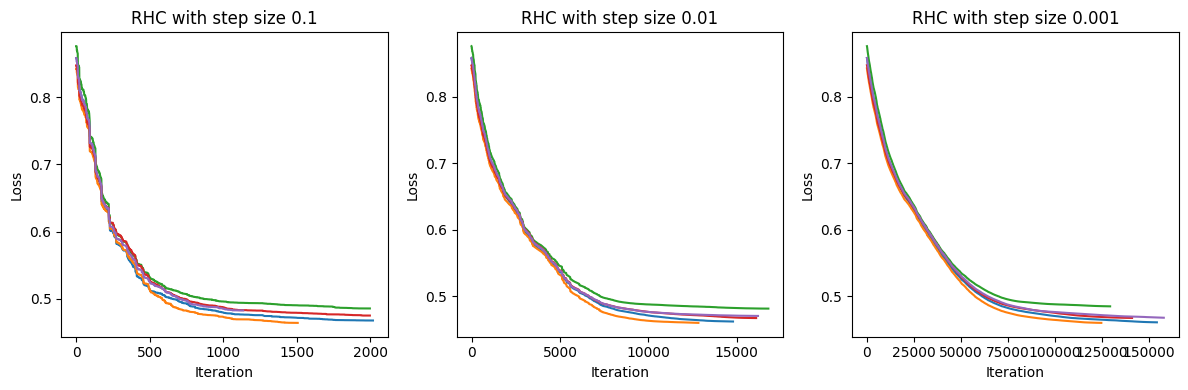

In [23]:

n_splits=5
steps=[0.1,0.01,0.001]
rhc_results=dict()

for s in steps:
    nn_params={
        'algorithm':'random_hill_climb',
        'max_attempts':50,
        'learning_rate':s

    }

    scoring_func=get_scorer(exp.scoring)
    mlp_cv=[mlrose.NeuralNetwork(hidden_nodes=[4],
                     activation='relu',
                     bias=True,
                     is_classifier=True,
                     max_iters=200000,
                     early_stopping=True,
                     clip_max=1e+2,
                     random_state=exp.random_state,
                     curve=True,**nn_params)]*n_splits

    skf=StratifiedKFold(shuffle=True,random_state=exp.random_state,n_splits=n_splits)
    folds=[]
    for train_idx,test_idx in skf.split(exp.X_train,exp.y_train):
        this_fold={'X_train':exp.X_train[train_idx],
                'y_train':exp.y_train[train_idx],
                'X_test':exp.X_train[test_idx],
                'y_test':exp.y_train[test_idx]}
        folds.append(this_fold)

    train_scores=np.zeros((n_splits))
    test_scores=np.zeros((n_splits))
    fitness_curves=[]
    n_evals=np.zeros((n_splits))
    n_iterations=np.zeros((n_splits))
    fit_times=np.zeros((n_splits))
    
    
    for i in range(n_splits):
        
        start_time=datetime.now()
        mlp_cv[i].fit(folds[i]['X_train'],folds[i]['y_train'])
        fit_times[i]=(datetime.now()-start_time).total_seconds()

        train_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_train'],folds[i]['y_train'])
        test_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_test'],folds[i]['y_test'])

        fitness_curves.append(mlp_cv[i].fitness_curve[:,0])
        n_evals[i]=(mlp_cv[i].fitness_curve[-1,1])
        n_iterations[i]=mlp_cv[i].fitness_curve.shape[0]
    
    print(f'=============Step size {s}======================')
    print(f'Train score: {np.mean(train_scores):.3f}')
    print(f'Test score: {np.mean(test_scores):.3f}')
    print(f'Iterations: {np.mean(n_iterations):.2f}')
    print(f'Evaluations: {np.mean(n_evals):.2f}')
    print(f'Fit Times: {np.mean(fit_times):.3}')


    rhc_results[s]={
        'train_scores':train_scores,
        'test_scores':test_scores,
        'fitness_curves': fitness_curves,
        'n_evals':n_evals,
        'n_iterations': n_iterations,
        'fit_times': fit_times
    }

fig,axs=plt.subplots(1,3,figsize=(12,4))

for ax,s in zip(axs,steps):
    for f in rhc_results[s]['fitness_curves']:
        ax.plot(f)
    ax.set_title(f'RHC with step size {s}')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    
plt.tight_layout()

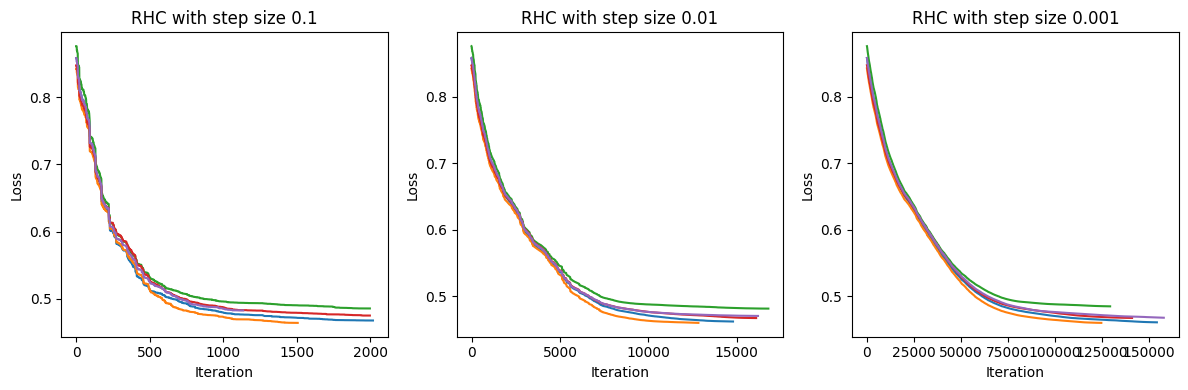

In [33]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
for ax,s in zip(axs,steps):
    for f in rhc_results[s]['fitness_curves']:
        ax.plot(f)
    ax.set_title(f'RHC with step size {s}')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    
    ax.ticklabel_format(style='sci',axis='x')
plt.tight_layout()

In [ ]:

n_splits=5
sa_results=dict()
temperature=[1,10,100]
decay=[0.9,0.99,0.999]
#schedule_list=[mlrose.GeomDecay(init_temp=t, decay=d) for t in temperature for d in decay]
for d in decay:
    nn_params={
        'algorithm':'simulated_annealing',
        'max_attempts':50,
        'learning_rate':0.001,
        'schedule':mlrose.GeomDecay(init_temp=1,decay=d,min_temp=0),


    }

    scoring_func=get_scorer(exp.scoring)
    mlp_cv=[mlrose.NeuralNetwork(hidden_nodes=[4],
                     activation='relu',
                     bias=True,
                     is_classifier=True,
                     max_iters=100000,
                     early_stopping=True,
                     clip_max=1e+0,
                     random_state=exp.random_state,
                     curve=True,**nn_params)]*n_splits

    skf=StratifiedKFold(shuffle=True,random_state=exp.random_state,n_splits=n_splits)
    folds=[]
    for train_idx,test_idx in skf.split(exp.X_train,exp.y_train):
        this_fold={'X_train':exp.X_train[train_idx],
                'y_train':exp.y_train[train_idx],
                'X_test':exp.X_train[test_idx],
                'y_test':exp.y_train[test_idx]}
        folds.append(this_fold)

    train_scores=np.zeros((n_splits))
    test_scores=np.zeros((n_splits))
    fitness_curves=[]
    n_evals=np.zeros((n_splits))
    n_iterations=np.zeros((n_splits))
    fit_times=np.zeros((n_splits))
    
    
    for i in range(n_splits):
        
        start_time=datetime.now()
        mlp_cv[i].fit(folds[i]['X_train'],folds[i]['y_train'])
        fit_times[i]=(datetime.now()-start_time).total_seconds()

        train_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_train'],folds[i]['y_train'])
        test_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_test'],folds[i]['y_test'])

        fitness_curves.append(mlp_cv[i].fitness_curve[:,0])
        n_evals[i]=(mlp_cv[i].fitness_curve[-1,1])
        n_iterations[i]=mlp_cv[i].fitness_curve.shape[0]
    
    print(f'=============Decay {d}======================')
    print(f'Train score: {np.mean(train_scores):.3f}')
    print(f'Test score: {np.mean(test_scores):.3f}')
    print(f'Iterations: {np.mean(n_iterations):.2f}')
    print(f'Evaluations: {np.mean(n_evals):.2f}')
    print(f'Fit Times: {np.mean(fit_times):.3}')


    sa_results[d]={
        'train_scores':train_scores,
        'test_scores':test_scores,
        'fitness_curves': fitness_curves,
        'n_evals':n_evals,
        'n_iterations': n_iterations,
        'fit_times': fit_times
    }

fig,axs=plt.subplots(1,3,figsize=(12,4))

for ax,d in zip(axs,decay):
    for f in sa_results[d]['fitness_curves']:
        ax.plot(f)
    ax.set_title(f'SA with Decay {d}')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    
plt.tight_layout()



=============Decay 0.9======================
Train score: 0.468
Test score: 0.468
Iterations: 7073.00
Evaluations: 10679.80
Fit Times: 2.87
=============Decay 0.99======================
Train score: 0.758
Test score: 0.743
Iterations: 74141.00
Evaluations: 109595.80
Fit Times: 29.8


0.686406847410497
0.6813877266387727


101108.0

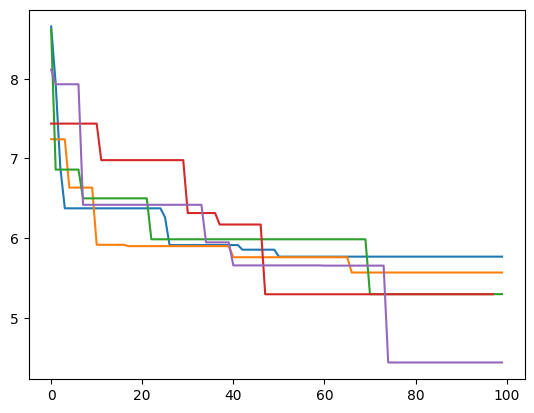

In [18]:

n_splits=5
nn_params={
    'algorithm':'genetic_alg',
    'max_attempts':50,
    'pop_size':1000,
    'mutation_prob':0.5
    
}

scoring_func=get_scorer(exp.scoring)
mlp_cv=[mlrose.NeuralNetwork(hidden_nodes=[4],
                 activation='relu',
                 bias=True,
                 is_classifier=True,
                 max_iters=100,
                 early_stopping=True,
                 clip_max=1e+10,
                 random_state=None,
                 curve=True,**nn_params)]*n_splits

skf=StratifiedKFold(shuffle=True,random_state=exp.random_state,n_splits=n_splits)
folds=[]
for train_idx,test_idx in skf.split(exp.X_train,exp.y_train):
    this_fold={'X_train':exp.X_train[train_idx],
            'y_train':exp.y_train[train_idx],
            'X_test':exp.X_train[test_idx],
            'y_test':exp.y_train[test_idx]}
    folds.append(this_fold)

train_scores=np.zeros((n_splits))
test_scores=np.zeros((n_splits))
fitness_curves=None

for i in range(n_splits):
    mlp_cv[i].fit(folds[i]['X_train'],folds[i]['y_train'])

    train_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_train'],folds[i]['y_train'])
    test_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_test'],folds[i]['y_test'])

    plt.plot(mlp_cv[i].fitness_curve[:,0])
    
    

print(np.mean(train_scores))
print(np.mean(test_scores))

np.mean([nn.fitness_curve[:,1][-1] for nn in mlp_cv])


=============Population Size 50======================
Train score: 0.617
Test score: 0.624
Iterations: 210.60
Evaluations: 10807.40
Fit Times: 3.25
=============Population Size 100======================
Train score: 0.673
Test score: 0.675
Iterations: 182.00
Evaluations: 18497.60
Fit Times: 5.68
=============Population Size 1000======================
Train score: 0.706
Test score: 0.697
Iterations: 214.80
Evaluations: 216031.20
Fit Times: 66.8


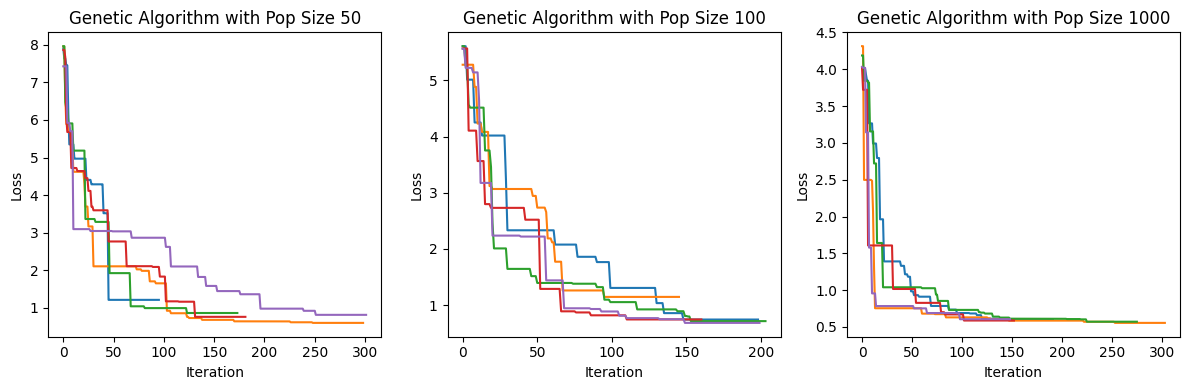

In [21]:

n_splits=5
ga_results=dict()
pop_size=[50,100,1000]
for p in pop_size:
    nn_params={
    'algorithm':'genetic_alg',
    'max_attempts':50,
    'pop_size':p,
    'mutation_prob':0.5
    }

    scoring_func=get_scorer(exp.scoring)
    mlp_cv=[mlrose.NeuralNetwork(hidden_nodes=[4],
                     activation='relu',
                     bias=True,
                     is_classifier=True,
                     max_iters=1000,
                     early_stopping=True,
                     clip_max=1e+1,
                     random_state=exp.random_state,
                     curve=True,**nn_params)]*n_splits

    skf=StratifiedKFold(shuffle=True,random_state=exp.random_state,n_splits=n_splits)
    folds=[]
    for train_idx,test_idx in skf.split(exp.X_train,exp.y_train):
        this_fold={'X_train':exp.X_train[train_idx],
                'y_train':exp.y_train[train_idx],
                'X_test':exp.X_train[test_idx],
                'y_test':exp.y_train[test_idx]}
        folds.append(this_fold)

    train_scores=np.zeros((n_splits))
    test_scores=np.zeros((n_splits))
    fitness_curves=[]
    n_evals=np.zeros((n_splits))
    n_iterations=np.zeros((n_splits))
    fit_times=np.zeros((n_splits))
    
    
    for i in range(n_splits):
        
        start_time=datetime.now()
        mlp_cv[i].fit(folds[i]['X_train'],folds[i]['y_train'])
        fit_times[i]=(datetime.now()-start_time).total_seconds()

        train_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_train'],folds[i]['y_train'])
        test_scores[i]=scoring_func(mlp_cv[i],folds[i]['X_test'],folds[i]['y_test'])

        fitness_curves.append(mlp_cv[i].fitness_curve[:,0])
        n_evals[i]=(mlp_cv[i].fitness_curve[-1,1])
        n_iterations[i]=mlp_cv[i].fitness_curve.shape[0]
    
    print(f'=============Population Size {p}======================')
    print(f'Train score: {np.mean(train_scores):.3f}')
    print(f'Test score: {np.mean(test_scores):.3f}')
    print(f'Iterations: {np.mean(n_iterations):.2f}')
    print(f'Evaluations: {np.mean(n_evals):.2f}')
    print(f'Fit Times: {np.mean(fit_times):.3}')


    ga_results[p]={
        'train_scores':train_scores,
        'test_scores':test_scores,
        'fitness_curves': fitness_curves,
        'n_evals':n_evals,
        'n_iterations': n_iterations,
        'fit_times': fit_times
    }



fig,axs=plt.subplots(1,3,figsize=(12,4))

for ax,p in zip(axs,pop_size):
    for f in ga_results[p]['fitness_curves']:
        ax.plot(f)
    ax.set_title(f'Genetic Algorithm with Pop Size {p}')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    
plt.tight_layout()

